## Download Dataset from here:

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp


Emotion_Detection_Data/
├── train.txt
├── val.txt
└── test.txt

In [13]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True (dynamic allocation like PyTorch)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Set TensorFlow to use dynamic GPU memory allocation.")
    except RuntimeError as e:
        print(e)

Set TensorFlow to use dynamic GPU memory allocation.


In [3]:
# Load Data

def load_data(filepath):
    texts, labels = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if ';' in line:
                text, label = line.strip().rsplit(';', 1)
                texts.append(text)
                labels.append(label)
    return texts, labels

X_train, y_train = load_data("Emotion_Detection_Data/train.txt")
X_val, y_val = load_data("Emotion_Detection_Data/val.txt")

In [4]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
num_classes = len(le.classes_)

In [5]:
# Tokenize

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=100)
X_val_pad = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=100)

In [6]:
# Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1747332441.944270  226026 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9491 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
# Train

history = model.fit(X_train_pad, y_train, epochs=20, validation_data=(X_val_pad, y_val))

Epoch 1/20


I0000 00:00:1747332443.312750  230222 cuda_dnn.cc:529] Loaded cuDNN version 90300


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4241 - loss: 1.4461 - val_accuracy: 0.7735 - val_loss: 0.6574
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8404 - loss: 0.4714 - val_accuracy: 0.8935 - val_loss: 0.3137
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9376 - loss: 0.1990 - val_accuracy: 0.9110 - val_loss: 0.2730
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9663 - loss: 0.1025 - val_accuracy: 0.9150 - val_loss: 0.2550
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9768 - loss: 0.0695 - val_accuracy: 0.9115 - val_loss: 0.2625
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9845 - loss: 0.0501 - val_accuracy: 0.9085 - val_loss: 0.3357
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9824 - loss: 0.0461 - val_accuracy: 0.9120 - val_loss: 0.2941
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9878 - loss: 0.0369 - val_accuracy: 0.9010 - val_

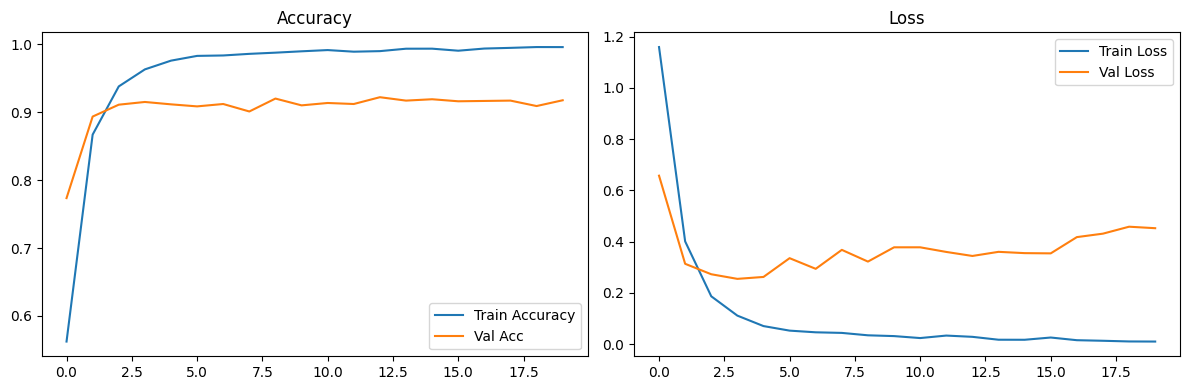

In [8]:
# --- Plot training history ---

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title("Loss")

plt.tight_layout()
plt.show()

In [9]:
# --- Evaluation ---

y_pred_probs = model.predict(X_val_pad)
y_pred = y_pred_probs.argmax(axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [10]:
# Classification report

print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))


Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.93      0.92       275
        fear       0.85      0.88      0.87       212
         joy       0.94      0.93      0.93       704
        love       0.83      0.85      0.84       178
     sadness       0.95      0.95      0.95       550
    surprise       0.84      0.84      0.84        81

    accuracy                           0.92      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.92      0.92      0.92      2000



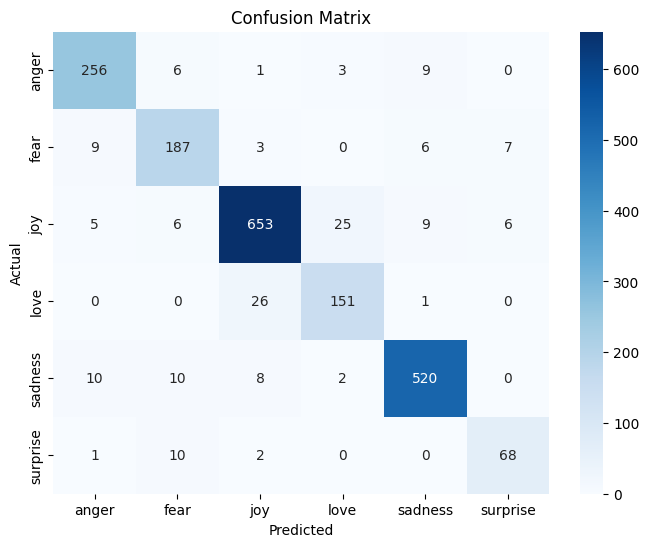

In [11]:
# Confusion Matrix

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted'), plt.ylabel('Actual'), plt.title('Confusion Matrix')
plt.show()